# Setup

In [1]:
import warnings

import numpy as np
import pandas as pd

import cv2
from PIL import Image
from matplotlib import pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

## Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = np.array(self.images[idx])
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)

        return sample

In [3]:
def load_data(path='datasets/fer2013/fer2013.csv'):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer2013, emotion_mapping

In [4]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [5]:
def get_dataloaders(path='datasets/fer2013/fer2013.csv', bs=64):
    """ Prepare train, val, & test dataloaders
        Augment training data using:
            - cropping
            - shifting (vertical/horizental)
            - horizental flipping
            - rotation

        input: path to fer2013 csv file
        output: (Dataloader, Dataloader, Dataloader) """

    fer2013, emotion_mapping = load_data(path)

    xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
    xval, yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
    xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

    mu, st = 0, 255
    test_transform = transforms.Compose([
        transforms.Resize(40),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mu,), std=(st,))
    ])

    train = CustomDataset(xtrain, ytrain, test_transform)
    val = CustomDataset(xval, yval, test_transform)
    test = CustomDataset(xtest, ytest, test_transform)

    trainloader = DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
    valloader = DataLoader(val, batch_size=bs, shuffle=True, num_workers=2)
    testloader = DataLoader(test, batch_size=bs, shuffle=True, num_workers=2)

    return trainloader, valloader, testloader

In [6]:
# Setup Dataset
trainloader, valloader, testloader = get_dataloaders(bs=1)

## Model Architecture

In [7]:
class Vgg(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.lin3 = nn.Linear(4096, 7)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        
        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))
        x = self.lin3(x)

        return x

In [11]:
# Load Trained Model
checkpoint = torch.load('vggcheckpoints/myvgg/epoch_300',map_location=torch.device('cpu'))

net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])
net.eval()

Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

# Saliency Analysis

In [12]:
# get image from trainloader
image, label = next(iter(trainloader))
image_plt = torch.squeeze(image)

# activate gradients for input/image
image = image.to(device)
image.requires_grad_()
print(image.requires_grad)

True


In [13]:
# pass image through network
output = net(image)

# get prediction and score
prediction = output.argmax()
output_max = output[0, prediction]

# backprop score
output_max.backward()

# calculate saliency
saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
saliency = saliency.reshape(40, 40)

# rescale between 0 and 1
saliency -= saliency.min(1, keepdim=True)[0]
saliency /= saliency.max(1, keepdim=True)[0]

print("Ground Truth:", label)
print("Prediction:", prediction)

Ground Truth: tensor([2])
Prediction: tensor(2, device='cuda:0')


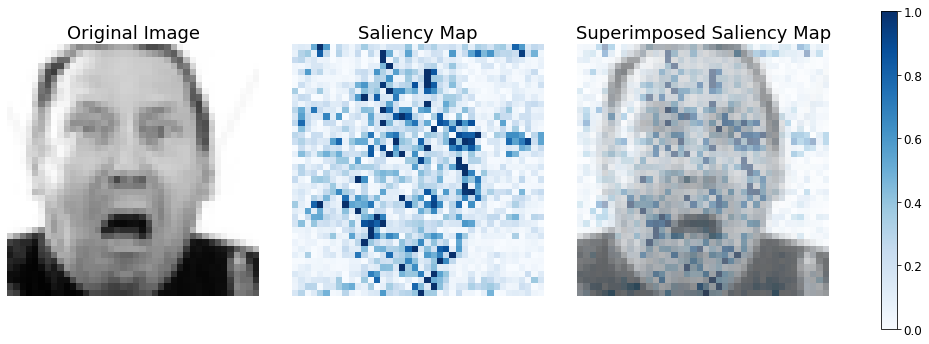

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plt.tight_layout()

axs[0].set_title('Original Image', fontsize=18)
axs[0].imshow(image_plt, cmap = 'gray')
axs[0].axis('off')

axs[1].set_title('Saliency Map', fontsize=18)
im = axs[1].imshow(saliency.cpu(), cmap='Blues')
axs[1].axis('off')

axs[2].set_title('Superimposed Saliency Map', fontsize=18)
axs[2].imshow(image_plt, cmap = 'gray')
axs[2].imshow(saliency.cpu(), cmap='Blues', alpha=0.4)
axs[2].axis('off')

cbar = fig.colorbar(im, ax=axs.ravel().tolist())
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(12)

plt.savefig("saliency.png", bbox_inches = 'tight')
plt.show()